Hypothesis 1:

Feed in model 1 row with race info and 8 motorbike to predict probability each motorbike to win (model output with 'softmax' activation) and sort motorbikes order by probability to win.

Hypothesis 2 (file autorace_prediction_hyp2.ipynb):

Build 8 models for each motorbike number with softmax output activation (8 classes).
Each model predict place in the race for it's motorbike number.

In this case Y_train label will be the place in the race for this motorbike.

Total 8 x_train datasets, 8 y_train datasets

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D,MaxPooling1D, Activation, Reshape, GaussianNoise
import keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, CategoricalCrossentropy 
from keras.utils import plot_model
from keras.models import load_model
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from tqdm import tqdm
import logging

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
data_to_predict_initial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/autorace/predict.csv')

# Get columns from dataset to predict
all_columns = data_to_predict_initial.columns.to_list()
all_columns.append('win_motorbike')

In [32]:
data_initial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/autorace/race_2008_2015.csv')
data_initial.head()

,raceinfo_id,hold_date,place_num,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,all_refund,all_race_order,xorder,racetime,all_racetime,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,...,p2_Other_180_All_All_raceaccident,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time
0,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,1,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,3,3.409,106.7017,30,3.32,1,0.088,3.408,3.438,59,6,A-37,S-38,81.724,0,3,3,3,30.0,60.0,3.34,3.428,3.410,21,...,0.0,3.397,3.34,0.18,3.430,3.460,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438
1,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,2,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,2,3.403,106.5139,30,3.29,1,0.099,3.389,3.419,32,26,S-52,S-50,89.141,0,1,2,6,10.0,30.0,3.33,3.429,3.383,24,...,0.0,3.395,3.30,0.17,3.322,3.352,3.45,3.498,8,0,0,2,2,0,0.0,0.0,25.0,0.0,3.395,3.30,0.18,3.338,3.368,3.43,3.489,2,0,0,1,1,0,0.0,0.0,50.0,0.0,3.422,3.38,0.14,3.349,3.379
2,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,3,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,6,3.452,107.7024,20,3.36,1,0.083,3.443,3.463,35,24,A-90,A-72,75.002,1,0,0,8,10.0,10.0,3.36,3.443,3.428,13,...,50.0,3.447,3.43,0.20,3.377,3.397,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463
3,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,4,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,5,3.436,107.2032,20,3.35,1,0.071,3.421,3.441,33,26,A-18,A-87,84.382,1,0,2,7,10.0,30.0,3.35,3.421,3.397,24,...,0.0,3.395,3.34,0.17,3.402,3.422,3.45,3.492,4,0,0,1,1,0,0.0,0.0,25.0,0.0,3.429,3.37,0.18,3.392,3.412,3.52,3.540,2,0,0,0,1,0,0.0,0.0,0.0,0.0,3.449,3.41,0.12,3.370,3.390
4,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,5,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,8,3.502,108.9122,10,3.36,1,0.084,3.444,3.454,29,29,A-172,B-1,64.817,1,1,1,6,22.2,33.3,3.38,3.464,3.441,15,...,0.0,3.436,3.37,0.18,3.341,3.351,3.39,3.436,1,0,0,0,1,0,0.0,0.0,0.0,0.0,3.436,3.39,0.16,3.406,3.416,3.38,3.464,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.444,3.454


In [33]:
# Add win_motorbike column to dataset
def get_win_motorbike(all_race_order):
  return all_race_order.split('_')[0]

data = data_initial.copy()
data['win_motorbike'] = data['all_race_order'].apply(get_win_motorbike).astype('int')

# Keep only columns without result (as in dataset to predict)
data = data[all_columns]
data.head(3)


,raceinfo_id,place_num,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,...,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time,win_motorbike
0,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,1,30,3.32,1,0.088,3.408,3.438,59,6,A-37,S-38,81.724,0,3,3,3,30.0,60.0,3.34,3.428,3.410,21,1,0,3.410,kawaguchi,1,0.14,...,3.397,3.34,0.18,3.430,3.460,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,3.408,3.438,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438,7
1,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,2,30,3.29,1,0.099,3.389,3.419,32,26,S-52,S-50,89.141,0,1,2,6,10.0,30.0,3.33,3.429,3.383,24,2,0,3.383,kawaguchi,1,0.17,...,3.395,3.30,0.17,3.322,3.352,3.45,3.498,8,0,0,2,2,0,0.0,0.0,25.0,0.0,3.395,3.3,0.18,3.338,3.368,3.43,3.489,2,0,0,1,1,0,0.0,0.0,50.0,0.0,3.422,3.38,0.14,3.349,3.379,7
2,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,3,20,3.36,1,0.083,3.443,3.463,35,24,A-90,A-72,75.002,1,0,0,8,10.0,10.0,3.36,3.443,3.428,13,1,0,3.428,kawaguchi,1,0.18,...,3.447,3.43,0.20,3.377,3.397,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,3.443,3.463,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463,7


In [34]:
columns_to_encode = ['situation',
 'weather_name3',
 'last90_highplace',
 'place_code',
 'distance',
 'handicap',
 'last10_num1th',
 'last10_num2th',
 'last10_num3th',
 'last10_numother',
 'last90_numwin',
 'last90_numwinwin',
 'last90_highplace_home',
 'last180_rate1_numall',
 'last180_rate1_num2th',
 'last5_times1_home',
 'last5_times1_race',
 'last5_times1_handi',
 'last5_times1_order',
 'last5_times2_home',
 'last5_times2_race',
 'last5_times2_handi',
 'last5_times2_order',
 'last5_times3_home',
 'last5_times3_race',
 'last5_times3_handi',
 'last5_times3_order',
 'last5_times4_home',
 'last5_times4_race',
 'last5_times4_handi',
 'last5_times4_order',
 'last5_times5_home',
 'last5_times5_race',
 'last5_times5_handi',
 'last5_times5_order',
 'this_numwinwin',
 'this_numwin',
 'p2_0_180_All_All_numwinwin',
 'p2_0_90_All_Here_numwinwin',
 'p2_0_90_10_All_numwinwin',
 'p2_1_180_All_All_numwinwin',
 'p2_1_90_All_All_numwinwin',
 'p2_All_180_All_All_numwinwin',
 'p2_All_90_All_All_numwinwin',
 'p2_All_90_All_Here_numwinwin',
 'p2_All_90_10_All_numwinwin',
 'p2_All_90_10_Here_numwinwin',
 'raceno',
 'raceclass_code',
 'popular',
 'motorbikeno',
 'home']

In [35]:
columns_to_scale = ['roadtemp',
 'temp',
 'humid',
 'traialtime',
 'hensa',
 'shisou_hensa',
 'soutei_time',
 'age',
 'graduation',
 'rank_now',
 'rank_last',
 'point',
 'last10_rate2th',
 'last10_rate3th',
 'last10_trialave',
 'last10_raceave',
 'last10_racehigh',
 'last90_numall',
 'last90_hightime',
 'last90_stave',
 'last180_rate0_rate2th',
 'last180_rate0_numall',
 'last180_rate0_num2th',
 'last180_rate1_rate2th',
 'last5_times1_racetime',
 'last5_times1_trialtime',
 'last5_times1_sttime',
 'last5_times2_racetime',
 'last5_times2_trialtime',
 'last5_times2_sttime',
 'last5_times3_racetime',
 'last5_times3_trialtime',
 'last5_times3_sttime',
 'last5_times4_racetime',
 'last5_times4_trialtime',
 'last5_times4_sttime',
 'last5_times5_racetime',
 'last5_times5_trialtime',
 'last5_times5_sttime',
 'life_numwinwin',
 'life_numwin',
 'p2_0_180_All_All_trialavg',
 'p2_0_180_All_All_raceave',
 'p2_0_180_All_All_numall',
 'p2_0_180_All_All_num1th',
 'p2_0_180_All_All_num2th',
 'p2_0_180_All_All_num3th',
 'p2_0_180_All_All_numwin',
 'p2_0_180_All_All_rate1th',
 'p2_0_180_All_All_rate2th',
 'p2_0_180_All_All_rate3th',
 'p2_0_180_All_All_raceaccident',
 'p2_0_180_All_All_racehigh',
 'p2_0_180_All_All_traialhigh',
 'p2_0_180_All_All_stave',
 'p2_0_180_All_All_shisou_hensa',
 'p2_0_180_All_All_soutei_time',
 'p2_0_90_All_All_trialavg',
 'p2_0_90_All_All_raceave',
 'p2_0_90_All_All_numall',
 'p2_0_90_All_All_num1th',
 'p2_0_90_All_All_num2th',
 'p2_0_90_All_All_num3th',
 'p2_0_90_All_All_numwin',
 'p2_0_90_All_All_numwinwin',
 'p2_0_90_All_All_rate1th',
 'p2_0_90_All_All_rate2th',
 'p2_0_90_All_All_rate3th',
 'p2_0_90_All_All_raceaccident',
 'p2_0_90_All_All_racehigh',
 'p2_0_90_All_All_traialhigh',
 'p2_0_90_All_All_stave',
 'p2_0_90_All_All_shisou_hensa',
 'p2_0_90_All_All_soutei_time',
 'p2_0_90_All_Here_trialavg',
 'p2_0_90_All_Here_raceave',
 'p2_0_90_All_Here_numall',
 'p2_0_90_All_Here_num1th',
 'p2_0_90_All_Here_num2th',
 'p2_0_90_All_Here_num3th',
 'p2_0_90_All_Here_numwin',
 'p2_0_90_All_Here_rate1th',
 'p2_0_90_All_Here_rate2th',
 'p2_0_90_All_Here_rate3th',
 'p2_0_90_All_Here_raceaccident',
 'p2_0_90_All_Here_racehigh',
 'p2_0_90_All_Here_traialhigh',
 'p2_0_90_All_Here_stave',
 'p2_0_90_All_Here_shisou_hensa',
 'p2_0_90_All_Here_soutei_time',
 'p2_0_90_10_All_trialavg',
 'p2_0_90_10_All_raceave',
 'p2_0_90_10_All_numall',
 'p2_0_90_10_All_num1th',
 'p2_0_90_10_All_num2th',
 'p2_0_90_10_All_num3th',
 'p2_0_90_10_All_numwin',
 'p2_0_90_10_All_rate1th',
 'p2_0_90_10_All_rate2th',
 'p2_0_90_10_All_rate3th',
 'p2_0_90_10_All_raceaccident',
 'p2_0_90_10_All_racehigh',
 'p2_0_90_10_All_traialhigh',
 'p2_0_90_10_All_stave',
 'p2_0_90_10_All_shisou_hensa',
 'p2_0_90_10_All_soutei_time',
 'p2_1_180_All_All_trialavg',
 'p2_1_180_All_All_raceave',
 'p2_1_180_All_All_numall',
 'p2_1_180_All_All_num1th',
 'p2_1_180_All_All_num2th',
 'p2_1_180_All_All_num3th',
 'p2_1_180_All_All_numwin',
 'p2_1_180_All_All_rate1th',
 'p2_1_180_All_All_rate2th',
 'p2_1_180_All_All_rate3th',
 'p2_1_180_All_All_raceaccident',
 'p2_1_180_All_All_racehigh',
 'p2_1_180_All_All_traialhigh',
 'p2_1_180_All_All_stave',
 'p2_1_180_All_All_shisou_hensa',
 'p2_1_180_All_All_soutei_time',
 'p2_1_90_All_All_trialavg',
 'p2_1_90_All_All_raceave',
 'p2_1_90_All_All_numall',
 'p2_1_90_All_All_num1th',
 'p2_1_90_All_All_num2th',
 'p2_1_90_All_All_num3th',
 'p2_1_90_All_All_numwin',
 'p2_1_90_All_All_rate1th',
 'p2_1_90_All_All_rate2th',
 'p2_1_90_All_All_rate3th',
 'p2_1_90_All_All_raceaccident',
 'p2_1_90_All_All_racehigh',
 'p2_1_90_All_All_traialhigh',
 'p2_1_90_All_All_stave',
 'p2_1_90_All_All_shisou_hensa',
 'p2_1_90_All_All_soutei_time',
 'p2_1_90_All_Here_trialavg',
 'p2_1_90_All_Here_raceave',
 'p2_1_90_All_Here_numall',
 'p2_1_90_All_Here_num1th',
 'p2_1_90_All_Here_num2th',
 'p2_1_90_All_Here_num3th',
 'p2_1_90_All_Here_numwin',
 'p2_1_90_All_Here_numwinwin',
 'p2_1_90_All_Here_rate1th',
 'p2_1_90_All_Here_rate2th',
 'p2_1_90_All_Here_rate3th',
 'p2_1_90_All_Here_raceaccident',
 'p2_1_90_All_Here_racehigh',
 'p2_1_90_All_Here_traialhigh',
 'p2_1_90_All_Here_stave',
 'p2_1_90_All_Here_shisou_hensa',
 'p2_1_90_All_Here_soutei_time',
 'p2_All_180_All_All_trialavg',
 'p2_All_180_All_All_raceave',
 'p2_All_180_All_All_numall',
 'p2_All_180_All_All_num1th',
 'p2_All_180_All_All_num2th',
 'p2_All_180_All_All_num3th',
 'p2_All_180_All_All_numwin',
 'p2_All_180_All_All_rate1th',
 'p2_All_180_All_All_rate2th',
 'p2_All_180_All_All_rate3th',
 'p2_All_180_All_All_raceaccident',
 'p2_All_180_All_All_racehigh',
 'p2_All_180_All_All_traialhigh',
 'p2_All_180_All_All_stave',
 'p2_All_180_All_All_shisou_hensa',
 'p2_All_180_All_All_soutei_time',
 'p2_All_90_All_All_trialavg',
 'p2_All_90_All_All_raceave',
 'p2_All_90_All_All_numall',
 'p2_All_90_All_All_num1th',
 'p2_All_90_All_All_num2th',
 'p2_All_90_All_All_num3th',
 'p2_All_90_All_All_numwin',
 'p2_All_90_All_All_rate1th',
 'p2_All_90_All_All_rate2th',
 'p2_All_90_All_All_rate3th',
 'p2_All_90_All_All_raceaccident',
 'p2_All_90_All_All_racehigh',
 'p2_All_90_All_All_traialhigh',
 'p2_All_90_All_All_stave',
 'p2_All_90_All_All_shisou_hensa',
 'p2_All_90_All_All_soutei_time',
 'p2_All_90_All_Here_trialavg',
 'p2_All_90_All_Here_raceave',
 'p2_All_90_All_Here_numall',
 'p2_All_90_All_Here_num1th',
 'p2_All_90_All_Here_num2th',
 'p2_All_90_All_Here_num3th',
 'p2_All_90_All_Here_numwin',
 'p2_All_90_All_Here_rate1th',
 'p2_All_90_All_Here_rate2th',
 'p2_All_90_All_Here_rate3th',
 'p2_All_90_All_Here_raceaccident',
 'p2_All_90_All_Here_racehigh',
 'p2_All_90_All_Here_traialhigh',
 'p2_All_90_All_Here_stave',
 'p2_All_90_All_Here_shisou_hensa',
 'p2_All_90_All_Here_soutei_time',
 'p2_All_90_10_All_trialavg',
 'p2_All_90_10_All_raceave',
 'p2_All_90_10_All_numall',
 'p2_All_90_10_All_num1th',
 'p2_All_90_10_All_num2th',
 'p2_All_90_10_All_num3th',
 'p2_All_90_10_All_numwin',
 'p2_All_90_10_All_rate1th',
 'p2_All_90_10_All_rate2th',
 'p2_All_90_10_All_rate3th',
 'p2_All_90_10_All_raceaccident',
 'p2_All_90_10_All_racehigh',
 'p2_All_90_10_All_traialhigh',
 'p2_All_90_10_All_stave',
 'p2_All_90_10_All_shisou_hensa',
 'p2_All_90_10_All_soutei_time',
 'p2_All_90_10_Here_trialavg',
 'p2_All_90_10_Here_raceave',
 'p2_All_90_10_Here_numall',
 'p2_All_90_10_Here_num1th',
 'p2_All_90_10_Here_num2th',
 'p2_All_90_10_Here_num3th',
 'p2_All_90_10_Here_numwin',
 'p2_All_90_10_Here_rate1th',
 'p2_All_90_10_Here_rate2th',
 'p2_All_90_10_Here_rate3th',
 'p2_All_90_10_Here_raceaccident',
 'p2_All_90_10_Here_racehigh',
 'p2_All_90_10_Here_traialhigh',
 'p2_All_90_10_Here_stave',
 'p2_All_90_10_Here_shisou_hensa',
 'p2_All_90_10_Here_soutei_time',
 'p2_All_Life_All_All_trialavg',
 'p2_All_Life_All_All_raceave',
 'p2_All_Life_All_All_numall',
 'p2_All_Life_All_All_num1th',
 'p2_All_Life_All_All_num2th',
 'p2_All_Life_All_All_num3th',
 'p2_All_Life_All_All_numwin',
 'p2_All_Life_All_All_numwinwin',
 'p2_All_Life_All_All_rate1th',
 'p2_All_Life_All_All_rate2th',
 'p2_All_Life_All_All_rate3th',
 'p2_All_Life_All_All_raceaccident',
 'p2_All_Life_All_All_racehigh',
 'p2_All_Life_All_All_traialhigh',
 'p2_All_Life_All_All_stave',
 'p2_All_Life_All_All_shisou_hensa',
 'p2_All_Life_All_All_soutei_time',
 'p2_Other_180_All_All_trialavg',
 'p2_Other_180_All_All_raceave',
 'p2_Other_180_All_All_numall',
 'p2_Other_180_All_All_num1th',
 'p2_Other_180_All_All_num2th',
 'p2_Other_180_All_All_num3th',
 'p2_Other_180_All_All_numwin',
 'p2_Other_180_All_All_numwinwin',
 'p2_Other_180_All_All_rate1th',
 'p2_Other_180_All_All_rate2th',
 'p2_Other_180_All_All_rate3th',
 'p2_Other_180_All_All_raceaccident',
 'p2_Other_180_All_All_racehigh',
 'p2_Other_180_All_All_traialhigh',
 'p2_Other_180_All_All_stave',
 'p2_Other_180_All_All_shisou_hensa',
 'p2_Other_180_All_All_soutei_time',
 'p2_Other_90_All_All_trialavg',
 'p2_Other_90_All_All_raceave',
 'p2_Other_90_All_All_numall',
 'p2_Other_90_All_All_num1th',
 'p2_Other_90_All_All_num2th',
 'p2_Other_90_All_All_num3th',
 'p2_Other_90_All_All_numwin',
 'p2_Other_90_All_All_numwinwin',
 'p2_Other_90_All_All_rate1th',
 'p2_Other_90_All_All_rate2th',
 'p2_Other_90_All_All_rate3th',
 'p2_Other_90_All_All_raceaccident',
 'p2_Other_90_All_All_racehigh',
 'p2_Other_90_All_All_traialhigh',
 'p2_Other_90_All_All_stave',
 'p2_Other_90_All_All_shisou_hensa',
 'p2_Other_90_All_All_soutei_time',
 'p2_Other_90_All_Here_trialavg',
 'p2_Other_90_All_Here_raceave',
 'p2_Other_90_All_Here_numall',
 'p2_Other_90_All_Here_num1th',
 'p2_Other_90_All_Here_num2th',
 'p2_Other_90_All_Here_num3th',
 'p2_Other_90_All_Here_numwin',
 'p2_Other_90_All_Here_numwinwin',
 'p2_Other_90_All_Here_rate1th',
 'p2_Other_90_All_Here_rate2th',
 'p2_Other_90_All_Here_rate3th',
 'p2_Other_90_All_Here_raceaccident',
 'p2_Other_90_All_Here_racehigh',
 'p2_Other_90_All_Here_traialhigh',
 'p2_Other_90_All_Here_stave',
 'p2_Other_90_All_Here_shisou_hensa',
 'p2_Other_90_All_Here_soutei_time']

In [36]:
def replaceNaN(dataset) : 
  nullcolumns = []
  for c in dataset.columns :
      if dataset[c].isnull().any() : 
          nullcolumns.append(c)
          
  print('Before filling missing values' )
  print(nullcolumns)

  # fill average insted of missing value
  p2_columns = dataset.columns[dataset.columns.str.startswith('p2')]

  for column in p2_columns :
      dataset[column].fillna(dataset[column].mean(), inplace=True)

  # fill 0 instead of missing value
  for column in nullcolumns :
      dataset[column].fillna(0.0, inplace=True)
      
  # check NaN
  nullcolumns = []
  for c in dataset.columns :
      if dataset[c].isnull().any() : 
          nullcolumns.append(c)
          
  print('After filling missing values' )
  print(nullcolumns)

  return dataset

def calc_rank(x):
  if isinstance(x, float) :
      return 300;
  alpha = x[:1]
  num = int(x[2:])
  if alpha == 'S' :
      num = num
  elif alpha == 'A' :
      num += 100
  elif alpha == 'B' :
      num += 300
  elif alpha == 'C' :
      num += 400
  return num


def encode_to_labels(column, astype='str'):
  label_encoder = LabelEncoder()
  column = label_encoder.fit_transform(column.astype(astype))
  return column, label_encoder

def scale_column(column, column_name, train=True):
  scaler_filename=f"/content/drive/MyDrive/Colab Notebooks/autorace/scalers/scaler_{column_name}.save"
  if train:
    scaler = MinMaxScaler((0,1))
    column = scaler.fit_transform(column.values.reshape(-1,1))
    joblib.dump(scaler, scaler_filename)  # Save scaler for each column
  else:
    scaler = joblib.load(scaler_filename)  # Load scaler for each column
    column = scaler.transform(column.values.reshape(-1,1))
  return column

labels_dict = {}  # Dict to store labels number
def convert_data(data, train=True):
  del data['place_num']
  # Fill missing values
  data = replaceNaN(data)
  # Convert ranking to numbers
  data['rank_now'] = data['rank_now'].apply(calc_rank)
  data['rank_last'] = data['rank_last'].apply(calc_rank)

  # Encode columns
  for c in columns_to_encode:
    data[c], encoder = encode_to_labels(data[c])
    if train:
      # Keep labels for each column
      labels_dict.update([(c, len(encoder.classes_))])

  # Scale columns
  for c in columns_to_scale:
    if train:
      data[c] = scale_column(data[c], c)
    else:
      data[c] = scale_column(data[c], c, train=False)
  return data

In [37]:
data = convert_data(data)

Before filling missing values
['weather_name3', 'rank_last', 'last90_highplace', 'p2_0_180_All_All_stave', 'p2_0_90_All_All_stave', 'p2_1_90_All_Here_stave', 'p2_All_180_All_All_stave', 'p2_All_90_All_All_stave', 'p2_All_90_All_Here_stave', 'p2_All_90_10_All_stave', 'p2_All_90_10_Here_stave', 'p2_All_Life_All_All_stave', 'p2_Other_180_All_All_stave', 'p2_Other_90_All_All_stave', 'p2_Other_90_All_Here_stave']
After filling missing values
[]


In [10]:
data

,raceinfo_id,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,last180_rate0_rate2th,...,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time,win_motorbike
0,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,0,5,0.706383,1,0.394619,0.714465,0.720755,0.732143,0.161290,0.268775,0.072266,0.539361,0,3,3,4,0.300,0.600,0.885942,0.907599,0.902833,0.437500,1,0,0.829079,5,1,0.341463,0.366,...,0.787071,0.8350,0.428571,0.724460,0.728491,0.858612,0.847257,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000,0.0,0.000000,0.000000,0.000000,0.721718,0.725645,0.841310,0.822260,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.728390,0.731732,7
1,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,1,5,0.700000,1,0.443946,0.710482,0.716771,0.250000,0.806452,0.100791,0.095703,0.588312,0,1,2,7,0.100,0.300,0.883289,0.907863,0.895684,0.500000,2,0,0.822514,5,1,0.414634,0.200,...,0.786608,0.8250,0.404762,0.702035,0.705882,0.886889,0.864558,0.001259,0.000000,0.000000,0.001873,0.005797,0.0,0.000,0.000,0.250,0.0,0.844107,0.848329,0.310345,0.707267,0.711074,0.863980,0.836891,0.000331,0.000000,0.0,0.000975,0.003077,0.0,0.0,0.0,0.5,0.0,0.848710,0.851385,0.233333,0.716502,0.719723,7
2,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,2,4,0.714894,1,0.372197,0.721803,0.725996,0.303571,0.741935,0.373518,0.333984,0.494997,1,0,0,9,0.100,0.100,0.891247,0.911570,0.907599,0.270833,1,0,0.833455,5,1,0.439024,0.400,...,0.798656,0.8575,0.476190,0.713455,0.715302,0.863753,0.850964,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000,0.0,0.000000,0.000000,0.000000,0.728943,0.730849,0.846348,0.825858,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.735442,0.736821,7
3,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,3,4,0.712766,1,0.318386,0.717191,0.721384,0.267857,0.806452,0.231225,0.363281,0.556903,1,0,2,8,0.100,0.300,0.888594,0.905745,0.899391,0.500000,2,0,0.825918,5,1,0.414634,0.356,...,0.786608,0.8350,0.404762,0.718646,0.720536,0.886889,0.863075,0.000629,0.000000,0.000000,0.000936,0.002899,0.0,0.000,0.000,0.250,0.0,0.852561,0.866324,0.310345,0.718415,0.720233,0.886650,0.849124,0.000331,0.000000,0.0,0.000000,0.003077,0.0,0.0,0.0,0.0,0.0,0.855407,0.858942,0.200000,0.720733,0.721962,7
4,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,4,1,0.714894,1,0.376682,0.722013,0.724109,0.196429,0.903226,0.535573,0.585938,0.427779,1,1,1,7,0.222,0.333,0.896552,0.917130,0.911041,0.312500,1,0,0.835400,1,0,0.365854,0.270,...,0.796108,0.8425,

In [ ]:
# Preparing the lists of columns to label and to scale
columns_to_encode = []
columns_already_labeled = []
columns_already_labeled.append('win_motorbike')
# Encode_to_labels
data['situation'], _ = encode_to_labels(data['situation'])
data['weather_name3'], _ = encode_to_labels(data['weather_name3'])
data['last90_highplace'], place_encoder = encode_to_labels(data['last90_highplace'])
data['place_code'] = place_encoder.transform(data['place_code'])
columns_to_encode.extend(['situation', 'weather_name3', 'last90_highplace', 'place_code'])
columns_already_labeled.append(['situation', 'weather_name3', 'last90_highplace', 'place_code'])

# Encode int columns to labels where max value - nbr unique value < 2
columns_int_to_encode = []
columns_mask_to_encode = [x for x in ((data[data.columns[data.dtypes=='int']].max() - data[data.columns[data.dtypes=='int']].nunique()) < 2)]
for c  in (data[data.columns[data.dtypes=='int']].columns[columns_mask_to_encode]):
  if c not in columns_already_labeled and c not in columns_to_encode:
    data[c], _ = encode_to_labels(data[c], astype='int')
    columns_int_to_encode.append(c)

# Encode int columns to labels where max unique values <= 30
columns_int_to_encode = []
columns_mask_to_encode = [x for x in (data[data.columns[data.dtypes=='int']].nunique() <= 30 )]
for c  in (data[data.columns[data.dtypes=='int']].columns[columns_mask_to_encode]):
  if c not in columns_already_labeled and c not in columns_to_encode:
    data[c], _ = encode_to_labels(data[c], astype='int')
    columns_int_to_encode.append(c)

columns_to_scale = []
for c in data.columns:
  if c not in columns_already_labeled and c not in columns_to_encode and c not in columns_int_to_encode:
    columns_to_scale.append(c)

In [15]:
raceinfo_columns = ['place_num',
 'place_code',
 'raceno',
 'distance',
 'situation',
 'raceclass_code',
 'weather_name3',
 'popular',
 'roadtemp',
 'temp',
 'humid']

In [38]:
data.shape

(303149, 357)

In [42]:
 def tarnsform_data(data, train=True):
  x_train = []
  y_train = []
  group_by_data = data['raceinfo_id'].unique()
  # Transformation of dataset to array of vectors by race id
  for raceinfo_id in tqdm(group_by_data, position=0):
    # data by raceinfo_id
    row_df = data[data['raceinfo_id'] == raceinfo_id]
    if train:
      # add label
      y_train.append(row_df.win_motorbike.values[0])
      race_data_df = row_df.iloc[:,11:-1]  # Create dataset with motorbikes data. Without winmotorbike.
    else:
      race_data_df = row_df.iloc[:,11:]   # Create dataset with motorbikes data.

    # Transform race info columns
    race_info_df = row_df.iloc[:,:11]  # Create race info dataset
    x_info_temp = race_info_df.iloc[:,1].values.reshape(-1,1)  # Race info array
    # OHE for 1st column 'place_code'
    x_info_temp = to_categorical(x_info_temp, num_classes=labels_dict[race_info_df.columns[1]])
    for c in race_info_df.columns[2:]:
      if c in columns_to_encode:
        # Make OHE for columns if in list of columns to encode and add to race info array
        x_info_temp = np.hstack((x_info_temp, to_categorical(row_df[c].values.reshape(-1,1), num_classes=labels_dict[c])))
      else:
        # Just add to race info array
        x_info_temp = np.hstack((x_info_temp, row_df[c].values.reshape(-1,1)))
    # Add temp race info array to common array
    x_temp = x_info_temp[0]
    # Reshape and add 1st column to motorbike data array
    x_data_temp = race_data_df.iloc[:,0].values.reshape(-1,1)
    # OHE of 1st column
    x_data_temp = to_categorical(x_data_temp, num_classes=labels_dict[race_data_df.columns[0]])
    for c in race_data_df.columns[1:]:
      if c in columns_to_encode:
        # OHE and add column to motorbike data array
        x_data_temp = np.hstack((x_data_temp, to_categorical(race_data_df[c].values.reshape(-1,1), num_classes=labels_dict[c])))
      else:
        # Just add column to motorbike data array
        x_data_temp = np.hstack((x_data_temp, race_data_df[c].values.reshape(-1,1)))
    
    # Fill empty motorbikes by 0
    if race_data_df.shape[0] != 8:
      for i in range(8 - race_data_df.shape[0]):
        x_data_temp = np.vstack((x_data_temp, np.zeros(x_data_temp.shape[1])))

    # Flat the array with motorbikes
    x_data_temp = x_data_temp.flatten()
    # Add motorbikes array to race info array
    x_temp = np.hstack((x_temp, x_data_temp))
    #print(x_temp)
    
    x_train.append(x_temp)
    #print(x_train)

  x_train = np.array(x_train)
  if train:
    y_train = np.array(y_train).reshape(-1,1) - 1
    # OHE for Y
    y_train = to_categorical(y_train, num_classes=8)
    return x_train, y_train
  else:
    return x_train


In [43]:
x_train, y_train = tarnsform_data(data)

100%|██████████| 37945/37945 [12:14<00:00, 51.69it/s]


In [45]:
np.save('/content/drive/MyDrive/Colab Notebooks/autorace/x_train', x_train)
np.save('/content/drive/MyDrive/Colab Notebooks/autorace/y_train', y_train)

In [ ]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/autorace/x_train.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/autorace/y_train.npy')

In [46]:
# Split Train-Test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [47]:
# Split Train-Val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [48]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(24284, 7064)
(24284, 8)
(6072, 7064)
(6072, 8)
(7589, 7064)
(7589, 8)


In [49]:
#callback
file_name = 'autorace_prediction'
model_name = f'{file_name}'

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=90, min_lr=0.0000001, verbose=1, mode="max" )
early_stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=120, verbose=1,
    mode='max', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Colab Notebooks/autorace/{model_name}.h5', monitor='val_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

Epoch 1/100
49/49 [==============================] - 9s 144ms/step - loss: 2.5476 - accuracy: 0.1570 - val_loss: 2.0635 - val_accuracy: 0.2576

Epoch 00001: val_accuracy improved from -inf to 0.25758, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction.h5
Epoch 2/100
49/49 [==============================] - 7s 138ms/step - loss: 2.0449 - accuracy: 0.2254 - val_loss: 1.9955 - val_accuracy: 0.2599

Epoch 00002: val_accuracy improved from 0.25758 to 0.25988, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction.h5
Epoch 3/100
49/49 [==============================] - 7s 137ms/step - loss: 1.9729 - accuracy: 0.2555 - val_loss: 1.9591 - val_accuracy: 0.2686

Epoch 00003: val_accuracy improved from 0.25988 to 0.26861, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction.h5
Epoch 4/100
49/49 [==============================] - 7s 139ms/step - loss: 1.9380 - accuracy: 0.2613 - val_loss: 1.9284 - val_accu

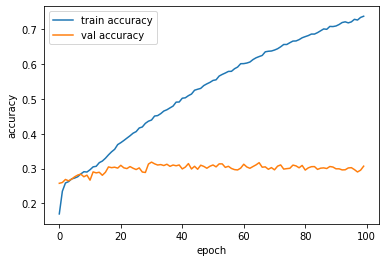

In [50]:
def create_model(x_train, y_train):
  model = Sequential()
  model.add(Dense(512, input_dim=(x_train.shape[1]), activation='relu'))
  model.add(GaussianNoise(1))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(GaussianNoise(1))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(GaussianNoise(1))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Flatten())
  model.add(Dense(y_train.shape[1], activation='softmax'))

  return model

model = create_model(x_train, y_train)
model.compile(optimizer=Adam(lr=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=100,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stop, checkpoint])


plt.plot(history.history['accuracy'], 
         label='train accuracy')
plt.plot(history.history['val_accuracy'], 
         label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**Need to work with overfitting**

# Prediction

In [51]:
data_to_predict = data_to_predict_initial.copy()
data_to_predict.head()

,raceinfo_id,place_num,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,...,p2_Other_180_All_All_raceaccident,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time
0,52674,2,kawaguchi,1,3100,good,3,sunny,2,14,9,39,1,0,3.46,1,0.066,3.526,3.526,64,13,B-103,B-108,43.985,0,0,0,10,0.0,0.0,3.47,3.536,3.500,22,0,0,3.500,kawaguchi,1,0.17,...,0.0,3.539,3.47,0.16,3.493,3.493,3.50,3.556,5,0,0,0,0,0,0.0,0.0,0.0,0.0,3.539,3.47,0.17,3.516,3.516,3.49,3.550,3,0,0,0,0,0,0.0,0.0,0.0,0.0,3.539,3.47,0.19,3.520,3.520
1,52674,2,kawaguchi,1,3100,good,3,sunny,2,14,9,39,2,0,3.42,0,0.097,3.517,3.517,48,21,B-101,B-88,45.820,0,1,0,9,10.0,10.0,3.43,3.527,3.506,20,0,0,3.506,kawaguchi,0,0.22,...,0.0,3.561,3.44,0.17,3.507,3.507,3.47,3.563,2,0,0,0,0,0,0.0,0.0,0.0,0.0,3.561,3.46,0.19,3.513,3.513,3.43,3.527,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.517,3.517
2,52674,2,kawaguchi,1,3100,good,3,sunny,2,14,9,39,3,10,3.41,0,0.086,3.496,3.506,53,20,B-82,B-86,49.582,0,1,1,8,10.0,20.0,3.42,3.506,3.474,21,0,0,3.474,iizuka,1,0.18,...,0.0,3.500,3.45,0.18,3.440,3.450,3.50,3.520,3,1,0,0,0,0,33.3,33.3,33.3,0.0,3.500,3.45,0.20,3.430,3.440,3.42,3.506,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.496,3.506
3,52674,2,kawaguchi,1,3100,good,3,sunny,2,14,9,39,4,10,3.36,1,0.095,3.455,3.465,63,12,B-51,B-55,53.643,0,2,2,6,20.0,40.0,3.40,3.495,3.481,25,0,0,3.477,kawaguchi,1,0.21,...,0.0,3.494,3.40,0.20,3.456,3.466,3.44,3.504,4,0,2,0,0,0,0.0,50.0,50.0,0.0,3.494,3.40,0.17,3.424,3.434,3.44,3.504,4,0,2,0,0,0,0.0,50.0,50.0,0.0,3.494,3.40,0.17,3.424,3.434
4,52674,2,kawaguchi,1,3100,good,3,sunny,2,14,9,39,5,20,3.35,1,0.097,3.447,3.467,42,25,A-227,B-37,59.579,1,2,2,5,30.0,50.0,3.38,3.477,3.460,28,0,0,3.458,hamamatsu,0,0.15,...,11.1,3.465,3.39,0.18,3.384,3.404,3.53,3.529,5,0,0,1,0,0,0.0,0.0,20.0,20.0,3.465,3.39,0.22,3.349,3.369,3.50,3.552,3,0,0,0,0,0,0.0,0.0,0.0,33.3,3.543,3.45,0.25,3.402,3.422


In [52]:
# Encode and scale data
data_to_predict = convert_data(data_to_predict, train=False)

Before filling missing values
['rank_last', 'point', 'last90_highplace', 'p2_0_90_10_All_stave', 'p2_All_90_All_All_stave', 'p2_All_90_10_All_stave', 'p2_All_Life_All_All_stave', 'p2_Other_90_All_All_stave']
After filling missing values
[]


In [ ]:
data_to_predict

In [54]:
from IPython.display import clear_output

In [61]:
predict_hit_rate = pd.DataFrame(columns=['hit_rate'])  # Dataframe to store results
id_list = data_to_predict['raceinfo_id'].unique()  # Get list of race_id
for raceinfo_id in tqdm(id_list, position=1):
  # Take only data for this race id
  row_df = data_to_predict[data_to_predict['raceinfo_id'] == raceinfo_id]
  # Make transformation of info part and motorbike part of dataset to vector
  x = tarnsform_data(row_df, train=False)
  # Make prediction
  pred = model.predict(x)
  # Sort results by probability to win
  sorted_pred = np.argsort(pred)[:,::-1]+1
  # Convert in output format
  pred_str = str(raceinfo_id)+',' + '_'.join(map(str, sorted_pred[0]))
  predict_hit_rate = predict_hit_rate.append({'hit_rate': pred_str}, ignore_index=True)
  clear_output(wait=True)

predict_hit_rate.to_csv('/content/drive/MyDrive/Colab Notebooks/autorace/predict_hit_rate.csv')

100%|██████████| 5049/5049 [08:19<00:00, 10.11it/s]


In [62]:
predict_hit_rate

,hit_rate
0,"52674,4_5_3_7_2_1_8_6"
1,"52675,7_4_6_5_2_8_3_1"
2,"52676,3_4_8_5_2_6_7_1"
3,"52677,8_6_5_3_4_1_7_2"
4,"52678,7_8_5_6_2_4_3_1"
...,...
5044,"62788,8_6_7_5_4_3_1_2"
5045,"62789,7_8_1_6_5_4_2_3"
5046,"62790,1_7_6_8_5_2_4_3"
5047,"62791,7_8_5_6_2_4_1_3"
